%load_ext autotime

### Instructions
1. Seek to improve the one-layer model by changing the internal activation function. This will involve changing A1 to something else, and also changing the derivative involving one or both of dAI and dZ1.
2. Add another layer with your choice of activation function (other than the logistic function) and your choice of internal nodes
3. Add a third layer
4. Add a fourth layer
5. Report on your choices and assessment of the resulting models - you can extend the basic model assessment tools supplied
6. Based on your answers to tasks 1-4, write code that - for this dataset - allows a user to build and run a neural net with a high degree of flexibility in terms of architecture and hyperperameter choices.
7. Explain how advanced optimisers (e.g. Adam) would extend your code

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

In [45]:
# Import the Dataset

df = pd.read_csv ('flower2D.csv')
print(df.shape)
print(df.info())
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.head()

(400, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  400 non-null    int64  
 1   X1          400 non-null    float64
 2   X2          400 non-null    float64
 3   Y           400 non-null    int64  
dtypes: float64(2), int64(2)
memory usage: 12.6 KB
None


,X1,X2,Y
0,0.005257,-0.303586,0
1,0.996098,3.461645,0
2,0.384404,2.392678,0
3,0.951043,3.282709,0
4,0.091932,1.066689,0


In [46]:
X, y = df[["X1","X2"]], np.array(df["Y"])
n_train = 300
random_seed = np.random.default_rng(1332)

classes = np.unique(y)
train_indices = []
test_indices = []

# use random seeding for replicating results
for cls in classes:
    cls_indices = np.where(y == cls)[0]
    random_seed.shuffle(cls_indices)
    n_cls_train = int(n_train * len(cls_indices) / len(y))
    train_indices.extend(cls_indices[:n_cls_train])
    test_indices.extend(cls_indices[n_cls_train:])

random_seed.shuffle(train_indices)
random_seed.shuffle(test_indices)

X_train, X_test = X.iloc[train_indices].values, X.iloc[test_indices].values
y_train, y_test = y[train_indices].reshape(-1,1), y[test_indices].reshape(-1,1)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(300, 2) (100, 2)
(300, 1) (100, 1)


In [47]:
print("Unique test labels and counts:", np.unique(y_test, return_counts=True))

Unique test labels and counts: (array([0, 1]), array([50, 50]))


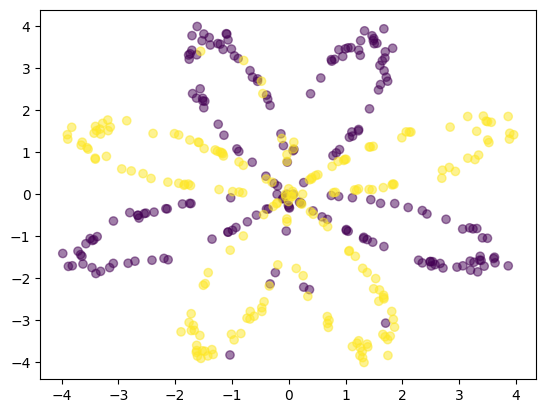

In [48]:
### Visualize the data
plt.scatter(df.X1, df.X2, c=df.Y, alpha=0.5)
plt.show()

### Shuffle the data
df = df.sample(frac=1)

### Preprocess into test and train sets

dataset, testDataset = np.split(df, [int(.7 * len(df))])
X = dataset.drop ('Y' , axis=1)
y = dataset['Y']
XX = testDataset.drop('Y', axis=1)
yy = testDataset['Y']

#### Loss & functions

In [49]:
def binary_cross_entropy(Y, Y_hat):
    m = Y.shape[0]
    return -(1/m) * np.sum(Y * np.log(Y_hat + 1e-15) + (1 - Y) * np.log(1 - Y_hat + 1e-15))

def binary_cross_entropy_grad(Y, Y_hat):
    m = Y.shape[0]
    return (Y_hat - Y) / (Y_hat * (1 - Y_hat) * m + 1e-15)

#### Neural network design
#### Activation Layers

In [50]:
class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        self.out = 1 / (1 + np.exp(-x))
        return self.out

    def backward(self, grad_output):
        return grad_output * self.out * (1 - self.out)

    def parameters_and_gradients(self):
        return []

class Relu:
    def __init__(self):
        self.out = None

    def forward(self, x):
        self.out = np.maximum(0, x)
        return self.out

    def backward(self, grad_output):
        return grad_output * (self.out > 0)

    def parameters_and_gradients(self):
        return []

#### Linear layer

In [51]:
class Linear:
    def __init__(self, input_dim, output_dim):
        self.weights = np.random.randn(input_dim, output_dim) * np.sqrt(2. / input_dim)
        self.biases = np.zeros((1, output_dim))
        self.input = None
        self.grad_weights = None
        self.grad_biases = None

    def forward(self, x):
        self.input = x
        return np.dot(x, self.weights) + self.biases

    def backward(self, grad_output):
        self.grad_weights = np.dot(self.input.T, grad_output)
        self.grad_biases = np.sum(grad_output, axis=0, keepdims=True)
        return np.dot(grad_output, self.weights.T)

    def parameters_and_gradients(self):
        return [(self.weights, self.grad_weights),
                (self.biases, self.grad_biases)]

#### Neural Network

In [52]:
class NeuralNetwork:
    def __init__(self, layers=[]):
        self.layers = layers

    def add_layer(self, layer):
        self.layers.append(layer)

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, grad_output):
        gradient_input = grad_output
        for layer in reversed(self.layers):
            gradient_input = layer.backward(gradient_input)

    def parameters_and_gradients(self):
        params_and_grads = []
        for layer in self.layers:
            params_and_grads.extend(layer.parameters_and_gradients())
        return params_and_grads

#### Training loop

In [53]:
def train(nn, loss_fun, loss_fun_grad, X_train, y_train, epochs=2000, learning_rate=0.01):
    
    for i in range(epochs):
        # Forward pass
        y_hat = nn.forward(X_train)
        
        # Compute loss
        loss = loss_fun(y_train, y_hat)
        
        # Backward pass
        grad_loss = loss_fun_grad(y_train, y_hat)
        nn.backward(grad_loss)
        
        # Update parameters
        for param, grad in nn.parameters_and_gradients():
            param -= learning_rate * grad
            
        if i % 200 == 0:
            print(f"Epoch {i}, loss: {loss:.4f}")

#### Classification report

In [54]:
def display_classification_report(nn, X_test, y_test):
    y_hat_test = nn.forward(X_test)
    
    predictions = (y_hat_test > 0.5).astype(int)
    labels = (y_test > 0.5).astype(int)
    
    predictions = predictions.flatten() 
    labels = labels.flatten()
    tp = np.sum((predictions == 1) & (labels == 1))
    tn = np.sum((predictions == 0) & (labels == 0))
    fp = np.sum((predictions == 1) & (labels == 0))
    fn = np.sum((predictions == 0) & (labels == 1))
    
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    report = pd.DataFrame({
        'Precision': [precision],
        'Recall': [recall],
        'F1-Score': [f1_score],
        'Accuracy': [accuracy],
    }, index=['BinaryClassifier'])
    
    return report

def display_confusion_matrix(nn, X_test, y_test):
    y_hat_test = nn.forward(X_test)

    predictions = (y_hat_test > 0.5).astype(int).flatten()
    labels = (y_test > 0.5).astype(int).flatten()

    # Confusion matrix values
    tp = np.sum((predictions == 1) & (labels == 1))
    tn = np.sum((predictions == 0) & (labels == 0))
    fp = np.sum((predictions == 1) & (labels == 0))
    fn = np.sum((predictions == 0) & (labels == 1))

    cm = np.array([[tn, fp],
                   [fn, tp]])

    model_score = (tn + tp) / (tn + fp + fn + tp)

    print("Confusion matrix:\n", cm)
    print("Model score:", model_score)


#### Visualisations

In [55]:
def display_decision_boundary(nn, X, X_train, y_train, title="Decision Boundary"):
    X_np = X.values
    
    # Create grid
    x_min, x_max = X_np[:,0].min() - 1, X_np[:,0].max() + 1
    y_min, y_max = X_np[:,1].min() - 1, X_np[:,1].max() + 1
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 200),
        np.linspace(y_min, y_max, 200)
    )
    points = np.c_[xx.ravel(), yy.ravel()]
    
    # Predictions
    Z = nn.forward(points)
    preds = (Z > 0.5).astype(int).flatten()
    
    # Plot decision boundary
    plt.figure(figsize=(8,6))
    plt.scatter(points[:,0], points[:,1], c=preds, alpha=0.2, cmap='coolwarm')
    plt.scatter(X_train[:,0], X_train[:,1], c=y_train.flatten(), edgecolor='k', cmap='coolwarm')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.title(title)
    plt.show()

### No hidden layers

In [56]:
nn = NeuralNetwork([
    Linear(X_train.shape[1], 1),  # input_dim = n_features
    Sigmoid()
])

learning_rate = 0.01
num_epochs = 2000

train(
    nn,
    binary_cross_entropy,
    binary_cross_entropy_grad,
    X_train,
    y_train,
)

for param, _ in nn.parameters_and_gradients():
    print(param)

Epoch 0, loss: 1.2666
Epoch 200, loss: 0.8379
Epoch 400, loss: 0.6755
Epoch 600, loss: 0.6590
Epoch 800, loss: 0.6583
Epoch 1000, loss: 0.6583
Epoch 1200, loss: 0.6583
Epoch 1400, loss: 0.6583
Epoch 1600, loss: 0.6583
Epoch 1800, loss: 0.6583
[[ 0.00955635]
 [-0.27437147]]
[[0.00608579]]


In [58]:
report = display_classification_report(nn, X_test, y_test)
print(report)

display_confusion_matrix(nn, X_test, y_test)

                  Precision  Recall  F1-Score  Accuracy
BinaryClassifier   0.446809    0.42   0.43299      0.45
Confusion matrix:
 [[24 26]
 [29 21]]
Model score: 0.45


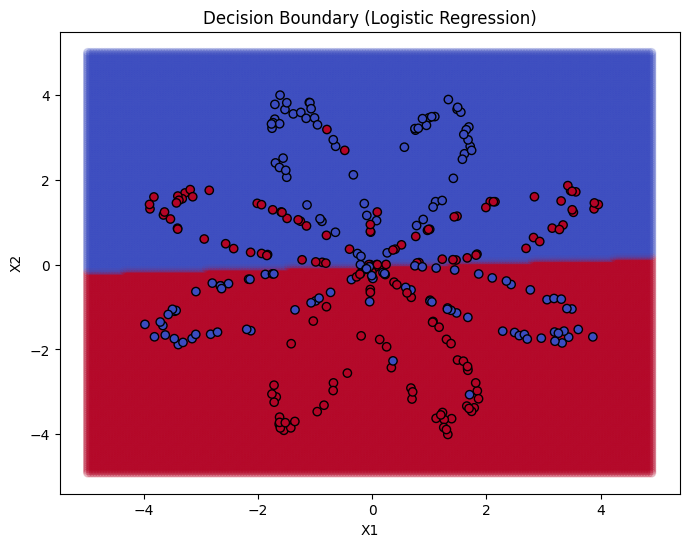

In [59]:
display_decision_boundary(nn, X, X_train, y_train, title="Decision Boundary (Logistic Regression)")

#### Swapping Sigmoid for ReLU

In [63]:
nn_2 = NeuralNetwork([
    Linear(X_train.shape[1], 1),  # input_dim = n_features
    Relu()
])

train(
    nn_2,
    binary_cross_entropy,
    binary_cross_entropy_grad,
    X_train,
    y_train,
)

for param, _ in nn.parameters_and_gradients():
    print(param)

Epoch 0, loss: nan
Epoch 200, loss: nan
Epoch 400, loss: nan
Epoch 600, loss: nan
Epoch 800, loss: nan
Epoch 1000, loss: nan
Epoch 1200, loss: nan
Epoch 1400, loss: nan
Epoch 1600, loss: nan
Epoch 1800, loss: nan
[[ 0.00955635]
 [-0.27437147]]
[[0.00608579]]


In [64]:
report = display_classification_report(nn_2, X_test, y_test)
print(report)

display_confusion_matrix(nn_2, X_test, y_test)

                  Precision  Recall  F1-Score  Accuracy
BinaryClassifier   0.574468    0.54  0.556701      0.57
Confusion matrix:
 [[30 20]
 [23 27]]
Model score: 0.57


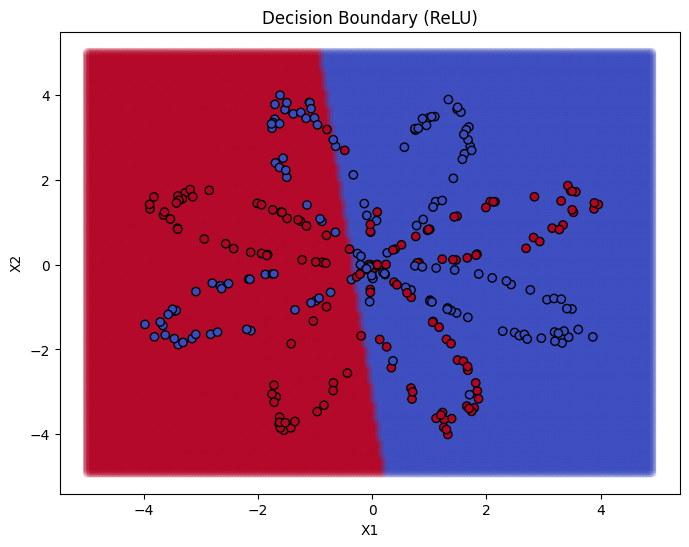

In [65]:
display_decision_boundary(nn_2, X, X_train, y_train, title="Decision Boundary (ReLU)")

#### With 1 hidden layer

In [72]:
hidden_units = 100

nn_3 = NeuralNetwork([
    Linear(X_train.shape[1], hidden_units),
    Relu(),
    Linear(hidden_units, 1),
    Sigmoid()
])

train(
    nn_3,
    binary_cross_entropy,
    binary_cross_entropy_grad,
    X_train,
    y_train,
)


Epoch 0, loss: 1.0957
Epoch 200, loss: 0.6525
Epoch 400, loss: 0.6450
Epoch 600, loss: 0.6378
Epoch 800, loss: 0.6300
Epoch 1000, loss: 0.6217
Epoch 1200, loss: 0.6124
Epoch 1400, loss: 0.6022
Epoch 1600, loss: 0.5907
Epoch 1800, loss: 0.5779


In [73]:
report = display_classification_report(nn_3, X_test, y_test)
print(report)

display_confusion_matrix(nn_3, X_test, y_test)

                  Precision  Recall  F1-Score  Accuracy
BinaryClassifier   0.695652    0.64  0.666667      0.68
Confusion matrix:
 [[36 14]
 [18 32]]
Model score: 0.68


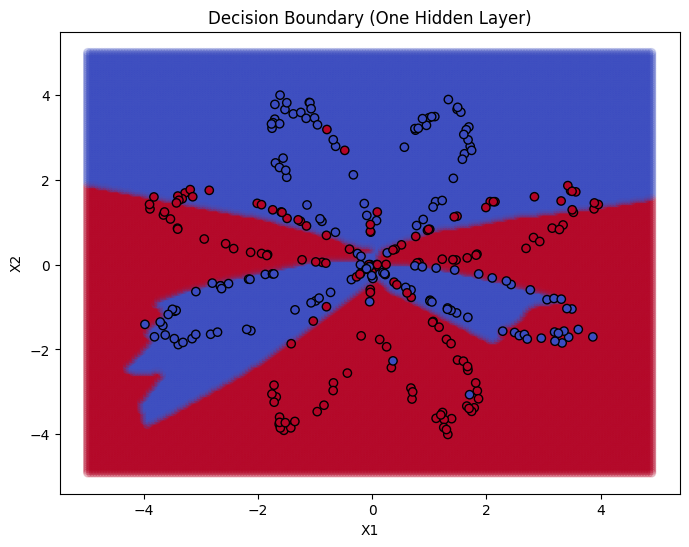

In [74]:
display_decision_boundary(nn_3, X, X_train, y_train, title="Decision Boundary (One Hidden Layer)")

#### Two hidden layers 

In [76]:
hidden_units = 100

nn_4 = NeuralNetwork([
    Linear(X_train.shape[1], hidden_units),
    Relu(),
    Linear(hidden_units, hidden_units),
    Relu(),
    Linear(hidden_units, 1),
    Sigmoid()
])

train(
    nn_4,
    binary_cross_entropy,
    binary_cross_entropy_grad,
    X_train,
    y_train,
)

Epoch 0, loss: 1.3090
Epoch 200, loss: 0.3143
Epoch 400, loss: 0.2813
Epoch 600, loss: 0.2654
Epoch 800, loss: 0.2537
Epoch 1000, loss: 0.2447
Epoch 1200, loss: 0.2370
Epoch 1400, loss: 0.2302
Epoch 1600, loss: 0.2242
Epoch 1800, loss: 0.2186


In [77]:
report = display_classification_report(nn_4, X_test, y_test)
print(report)

display_confusion_matrix(nn_4, X_test, y_test)

                  Precision  Recall  F1-Score  Accuracy
BinaryClassifier        0.9     0.9       0.9       0.9
Confusion matrix:
 [[45  5]
 [ 5 45]]
Model score: 0.9


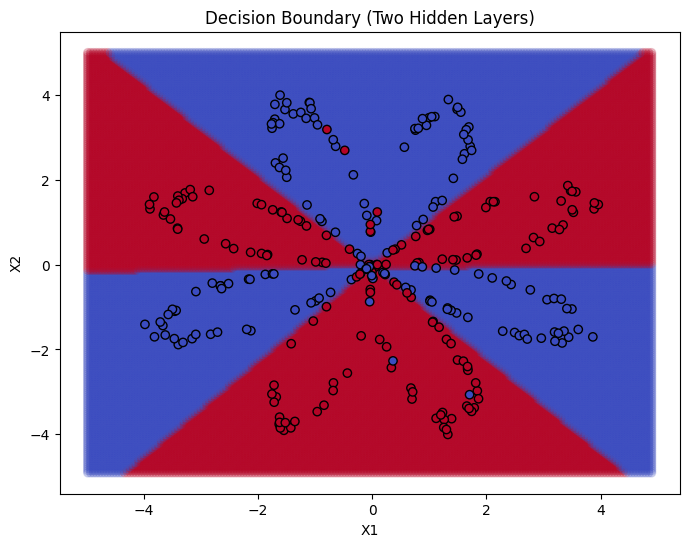

In [79]:
display_decision_boundary(nn_4, X, X_train, y_train, title="Decision Boundary (Two Hidden Layers)")

#### Three hidden layers

In [81]:
hidden_units = 100

nn_5 = NeuralNetwork([
    Linear(X_train.shape[1], hidden_units),
    Relu(),
    Linear(hidden_units, hidden_units),
    Relu(),
    Linear(hidden_units, hidden_units),
    Relu(),
    Linear(hidden_units, 1),
    Sigmoid()
])

train(
    nn_5,
    binary_cross_entropy,
    binary_cross_entropy_grad,
    X_train,
    y_train,
)

Epoch 0, loss: 1.2660
Epoch 200, loss: 0.2533
Epoch 400, loss: 0.2273
Epoch 600, loss: 0.2134
Epoch 800, loss: 0.2031
Epoch 1000, loss: 0.1944
Epoch 1200, loss: 0.1872
Epoch 1400, loss: 0.1815
Epoch 1600, loss: 0.1766
Epoch 1800, loss: 0.1721


In [82]:
report = display_classification_report(nn_5, X_test, y_test)
print(report)

display_confusion_matrix(nn_5, X_test, y_test)

                  Precision  Recall  F1-Score  Accuracy
BinaryClassifier   0.918367     0.9  0.909091      0.91
Confusion matrix:
 [[46  4]
 [ 5 45]]
Model score: 0.91


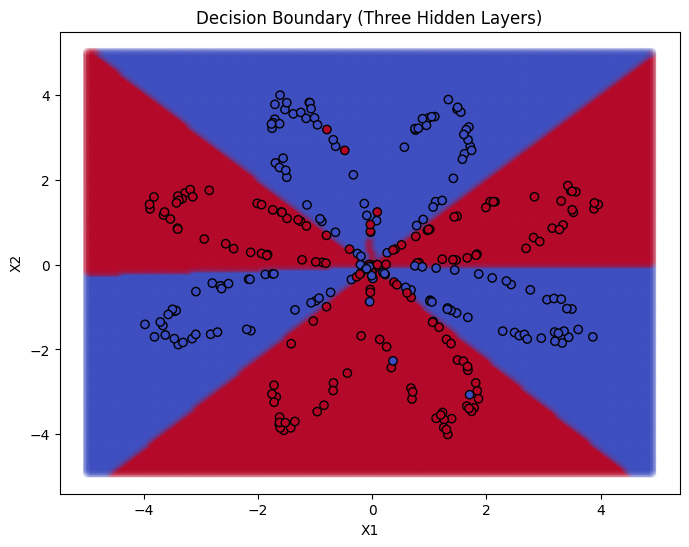

In [83]:
display_decision_boundary(nn_5, X, X_train, y_train, title="Decision Boundary (Three Hidden Layers)")

#### Four hidden layers 

In [84]:
hidden_units = 100

nn_6 = NeuralNetwork([
    Linear(X_train.shape[1], hidden_units),
    Relu(),
    Linear(hidden_units, hidden_units),
    Relu(),
    Linear(hidden_units, hidden_units),
    Relu(),
    Linear(hidden_units, hidden_units),
    Relu(),
    Linear(hidden_units, 1),
    Sigmoid()
])

train(
    nn_6,
    binary_cross_entropy,
    binary_cross_entropy_grad,
    X_train,
    y_train,
)

Epoch 0, loss: 1.0450
Epoch 200, loss: 0.2572
Epoch 400, loss: 0.2253
Epoch 600, loss: 0.2078
Epoch 800, loss: 0.1951
Epoch 1000, loss: 0.1854
Epoch 1200, loss: 0.1777
Epoch 1400, loss: 0.1710
Epoch 1600, loss: 0.1657
Epoch 1800, loss: 0.1611


In [85]:
report = display_classification_report(nn_6, X_test, y_test)
print(report)

display_confusion_matrix(nn_6, X_test, y_test)

                  Precision  Recall  F1-Score  Accuracy
BinaryClassifier   0.916667    0.88  0.897959       0.9
Confusion matrix:
 [[46  4]
 [ 6 44]]
Model score: 0.9


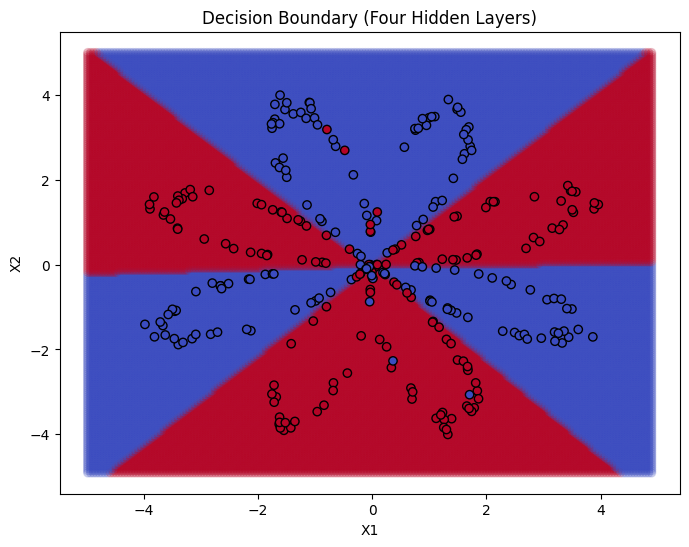

In [87]:
display_decision_boundary(nn_6, X, X_train, y_train, title="Decision Boundary (Four Hidden Layers)")

### Task 7 Adding an optimiser


The below code is prototype code to explain an example

In [88]:
# Super Class
class Optimiser:
    def step(self, param_and_grads):
        pass
    
# SGD
class SGD(Optimiser):
    def __init__(self, lr):
        self.lr = lr
        
    def step(self, param_and_grads):
        # SGD logic code...
        pass

# Adam
class Adam(Optimiser):
    def __init__(self, lr, beta_1, beta_2, epsilon=1e-8):
        self.lr = lr
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = epsilon
        self.m = {}
        self.v = {}
    
    def step(self, param_and_grads):
        # Adam logic code
        pass

# etc ...
class MyNewCoolOptimiser(Optimiser):
    def __init__(self, lr):
        self.lr = lr
    
    def step(self, param_and_grads):
        # logic code....
        pass

In [90]:
def train_prototype_with_optimiser(nn, loss_fun, loss_fun_grad, X_train, y_train, optimiser, epochs=2000):
    y_hat = nn.forward(X_train)
    
    loss = loss_fun(y_hat, y_train)
    
    grad_loss = loss_fun_grad(y_hat, y_train)
    nn.backward(grad_loss)
    
    optimiser.step(nn.parameters_and_gradients())
    
    # etc
